In [270]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [286]:
import pandas as pd
import json
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from scipy.stats import linregress
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import plotly_express as px
import numpy as np
import seaborn as sns
from glob import glob

In [287]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def find_kl_div_blowup(steps: List[Dict], threshold: float = 0.5) -> Tuple[int, float]:
    for step in steps:
        if step["kl_div"] >= threshold:
            return step["step"]
    # Return the last step and its normalized KL div if threshold is never reached
    return len(steps)


def classify_perturbation_type(steps: List[Dict]) -> str:
    kl_divs = [step["kl_div"] for step in steps]

    # Check for initial plateau
    initial_slope = linregress(range(10), kl_divs[:10]).slope

    # Check for rapid increase
    max_slope = max(kl_divs[i + 1] - kl_divs[i] for i in range(len(kl_divs) - 1))

    if initial_slope < 0.01 and max_slope > 0.1:
        return "plateau_then_rapid"
    elif all(kl_divs[i] <= kl_divs[i + 1] for i in range(len(kl_divs) - 1)):
        return "monotonic_increase"
    else:
        return "other"


def compute_prompt_embedding(prompt: List[int], model) -> np.ndarray:
    with torch.no_grad():
        # Convert token IDs to tensor
        tokens_tensor = torch.tensor(prompt).unsqueeze(0)  # Add batch dimension
        # Get embeddings
        embeddings = model.embed(tokens_tensor)
        # Average embeddings across token dimension
        mean_embedding = embeddings.mean(dim=1)
    return mean_embedding


def compute_prompt_cosine_sim(start_prompt, end_prompt, model):
    start_emb = compute_prompt_embedding(start_prompt, model)
    end_emb = compute_prompt_embedding(end_prompt, model)
    return torch.cosine_similarity(start_emb, end_emb).item()

## Finding KL div threshold

In [288]:
raw_observations = []

for filepath in glob("observations/*"):
    obs_data = load_jsonl(filepath)
    raw_observations.extend(obs_data)

In [289]:
len(raw_observations)

9000

Min normalized KL div: -1e-06
Max normalized KL div: 1.7730338999941113e-05
Mean normalized KL div: 1.001770463847774e-06
Median normalized KL div: 2.176180944059672e-07
95th percentile normalized KL div: 3.8380076634172085e-06


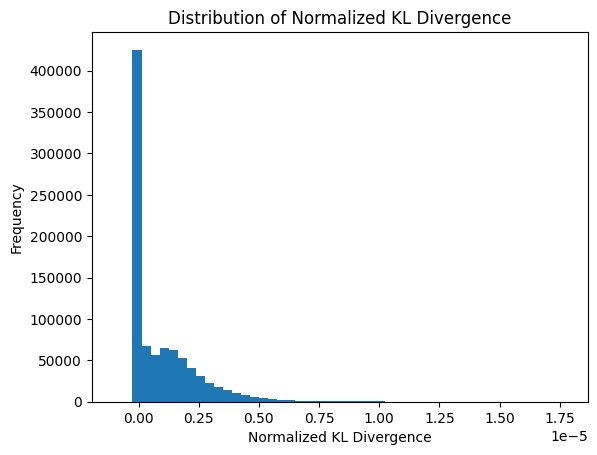

In [290]:
# Run this analysis on your observations
analyze_kl_div_distribution(raw_observations)

## Processing observations data

In [291]:
from transformer_lens import HookedTransformer
from collections import Counter, defaultdict

In [292]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [293]:
perturbation_layer = "blocks.0.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

sae.eval()

100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [294]:
def get_active_features_properties_sorted(step):
    feature_acts_total = sum(step["active_feature_acts"])
    active_feature_acts_norm = [
        round(a / feature_acts_total, 2) for a in step["active_feature_acts"]
    ]
    active_features_act_spars = sorted(
        zip(
            step["active_feature_ids"],
            active_feature_acts_norm,
            step["active_feature_sparsities"],
        ),
        key=lambda x: x[1],
        reverse=True,
    )
    return active_features_act_spars


def get_top_features_start_act(start_step, end_step):
    active_features_act_spars_start = get_active_features_properties_sorted(start_step)
    active_features_act_spars_end = get_active_features_properties_sorted(end_step)
    (
        (feat1, act_norm1, spars1),
        (feat2, act_norm2, spars2),
        (feat3, act_norm3, spars3),
    ) = active_features_act_spars_start[:3]

    feat1_end_info = [a for f, a, _ in active_features_act_spars_end if f == feat1]
    feat1_end_act = 0 if len(feat1_end_info) == 0 else feat1_end_info[0]

    feat2_end_info = [a for f, a, _ in active_features_act_spars_end if f == feat2]
    feat2_end_act = 0 if len(feat2_end_info) == 0 else feat2_end_info[0]

    feat3_end_info = [a for f, a, _ in active_features_act_spars_end if f == feat3]
    feat3_end_act = 0 if len(feat3_end_info) == 0 else feat3_end_info[0]

    return {
        f"start_act_top_1_sae_feature_id": feat1,
        f"start_act_top_1_sae_feature_act_norm_start": act_norm1,
        f"start_act_top_1_sae_feature_act_norm_end": feat1_end_act,
        f"start_act_top_1_sae_feature_sparsity": spars1,
        f"start_act_top_2_sae_feature_id": feat2,
        f"start_act_top_2_sae_feature_act_norm_start": act_norm2,
        f"start_act_top_2_sae_feature_act_norm_end": feat2_end_act,
        f"start_act_top_2_sae_feature_sparsity": spars2,
        f"start_act_top_3_sae_feature_id": feat3,
        f"start_act_top_3_sae_feature_act_norm_start": act_norm3,
        f"start_act_top_3_sae_feature_act_norm_end": feat3_end_act,
        f"start_act_top_3_sae_feature_sparsity": spars3,
    }


def get_top_features_end_act(start_step, end_step):
    active_features_act_spars_start = get_active_features_properties_sorted(start_step)
    active_features_act_spars_end = get_active_features_properties_sorted(end_step)
    (
        (feat1, act_norm1, spars1),
        (feat2, act_norm2, spars2),
        (feat3, act_norm3, spars3),
    ) = active_features_act_spars_end[:3]

    feat1_start_info = [a for f, a, _ in active_features_act_spars_start if f == feat1]
    feat1_start_act = 0 if len(feat1_start_info) == 0 else feat1_start_info[0]

    feat2_start_info = [a for f, a, _ in active_features_act_spars_start if f == feat2]
    feat2_start_act = 0 if len(feat2_start_info) == 0 else feat2_start_info[0]

    feat3_start_info = [a for f, a, _ in active_features_act_spars_start if f == feat3]
    feat3_start_act = 0 if len(feat3_start_info) == 0 else feat3_start_info[0]

    return {
        f"end_act_top_1_sae_feature_id": feat1,
        f"end_act_top_1_sae_feature_act_norm_start": feat1_start_act,
        f"end_act_top_1_sae_feature_act_norm_end": act_norm1,
        f"end_act_top_1_sae_feature_sparsity": spars1,
        f"end_act_top_2_sae_feature_id": feat2,
        f"end_act_top_2_sae_feature_act_norm_start": feat2_start_act,
        f"end_act_top_2_sae_feature_act_norm_end": act_norm2,
        f"end_act_top_2_sae_feature_sparsity": spars2,
        f"end_act_top_3_sae_feature_id": feat3,
        f"end_act_top_3_sae_feature_act_norm_start": feat3_start_act,
        f"end_act_top_3_sae_feature_act_norm_end": act_norm3,
        f"end_act_top_3_sae_feature_sparsity": spars3,
    }


def sae_derived_features(steps):
    num_steps = len(steps)
    all_active_features = [
        feature for step in steps for feature in step["active_feature_ids"]
    ]
    feature_counts = Counter(all_active_features)
    return {
        "total_unique_active_features": len(feature_counts),
        "max_feature_activation_count": (
            max(feature_counts.values()) / num_steps if feature_counts else 0
        ),
        "avg_feature_activation_count": (
            round((sum(feature_counts.values()) / len(feature_counts)) / num_steps, 4)
            if feature_counts
            else 0
        ),
        "avg_active_features": np.mean([step["num_active_features"] for step in steps]),
        "std_active_features": np.std([step["num_active_features"] for step in steps]),
        "avg_feature_activation": np.mean(
            [np.mean(step["active_feature_acts"]) for step in steps]
        ),
        "std_feature_activation": np.std(
            [np.mean(step["active_feature_acts"]) for step in steps]
        ),
        **get_top_features_start_act(steps[0], steps[-1]),
        **get_top_features_end_act(steps[0], steps[-1]),
    }


def find_plateau_length(steps: List[Dict], threshold: float = 0.01) -> int:
    kl_divs = [step["kl_div"] for step in steps]
    slopes = [kl_divs[i + 1] - kl_divs[i] for i in range(len(kl_divs) - 1)]

    for i, slope in enumerate(slopes):
        if abs(slope) > threshold:
            return i

    return len(steps) - 1

In [295]:
observations_features = []
seq_len = len(df.iloc[0].start_prompt)

for filepath in glob("observations/*"):
    obs_data = load_jsonl(filepath)
    for obs in obs_data:
        token_sim = len(set(obs["start_prompt"]) & set(obs["end_prompt"])) / seq_len

        observations_features.append(
            {
                "id": obs["id"],
                "start_prompt": model.tokenizer.decode(obs["start_prompt"]),
                "end_prompt": model.tokenizer.decode(obs["end_prompt"]),
                "prompts_cos_sim": compute_prompt_cosine_sim(
                    obs["start_prompt"], obs["end_prompt"], model
                ),
                "prompts_token_sim": token_sim,
                "kl_div_blowup_step": find_kl_div_blowup(obs["steps"]),
                "plateau_length": find_plateau_length(obs["steps"]),
                "perturbation_type": classify_perturbation_type(obs["steps"]),
                "final_kl_div": obs["steps"][-1]["kl_div"],
                "final_l2_norm": obs["steps"][-1]["l2_norm"],
                "final_cos_sim": obs["steps"][-1]["cos_sim"],
                **sae_derived_features(obs["steps"]),
            }
        )

df = pd.DataFrame(observations_features)

In [296]:
print(df.shape)
df.head()

(9000, 42)


,id,start_prompt,end_prompt,prompts_cos_sim,prompts_token_sim,kl_div_blowup_step,plateau_length,perturbation_type,final_kl_div,final_l2_norm,...,end_act_top_1_sae_feature_act_norm_end,end_act_top_1_sae_feature_sparsity,end_act_top_2_sae_feature_id,end_act_top_2_sae_feature_act_norm_start,end_act_top_2_sae_feature_act_norm_end,end_act_top_2_sae_feature_sparsity,end_act_top_3_sae_feature_id,end_act_top_3_sae_feature_act_norm_start,end_act_top_3_sae_feature_act_norm_end,end_act_top_3_sae_feature_sparsity
0,43d51517-af16-4cd5-8c43-e249c05a1b1f,"has ever seen.""[14] In 1758,",properties/rochester-castle/\n\nWhit,0.742881,0.0,55,26,plateau_then_rapid,7.133510,5.274225,...,0.17,0.000187,7550,0.00,0.06,0.128111,7034,0.00,0.05,0.080314
1,8b88d4d4-1c1c-45d8-9f7d-31830e604f72,"has ever seen.""[14] In 1758,",\nThe FAA said the Lockheed Martin-developed ER,0.779822,0.0,56,51,plateau_then_rapid,3.129138,4.465803,...,0.12,0.000509,22719,0.00,0.11,0.000368,7550,0.00,0.07,0.128111
2,5352ccd9-8b40-4d46-b804-962ae2795731,"has ever seen.""[14] In 1758,",the NYPD makes many skeptical of the proximat...,0.756930,0.0,55,50,plateau_then_rapid,2.223169,4.444928,...,0.48,0.000094,7550,0.00,0.10,0.128111,7034,0.00,0.09,0.080314
3,0d3a500d-5311-4c27-b21c-48c559298ca3,"has ever seen.""[14] In 1758,",battery storage just happened to come five da...,0.762875,0.0,51,44,plateau_then_rapid,3.072689,2.706066,...,0.53,0.014296,15603,0.05,0.10,0.119497,24182,0.05,0.07,0.090893
4,178aa2fd-07fd-4bc7-a8d2-05275bbd7161,"has ever seen.""[14] In 1758,",next elections.\n\nSARAH FERG,0.754920,0.0,50,22,plateau_then_rapid,2.565218,5.455506,...,0.10,0.000166,7550,0.00,0.07,0.128111,15603,0.05,0.06,0.119497


In [297]:
df.to_feather("data/dataset.feather")

## Plotting observations data

In [259]:
df.sample(5)

,id,start_prompt,end_prompt,prompts_cos_sim,prompts_token_sim,kl_div_blowup_step,plateau_length,perturbation_type,final_kl_div,final_l2_norm,...,end_act_top_1_sae_feature_act_norm_end,end_act_top_1_sae_feature_sparsity,end_act_top_2_sae_feature_id,end_act_top_2_sae_feature_act_norm_start,end_act_top_2_sae_feature_act_norm_end,end_act_top_2_sae_feature_sparsity,end_act_top_3_sae_feature_id,end_act_top_3_sae_feature_act_norm_start,end_act_top_3_sae_feature_act_norm_end,end_act_top_3_sae_feature_sparsity
802,dcf90194-c044-40c9-8f27-468d0060aba2,"poor healthcare facilities, always a thorn to...",- Speedingturtle: SNAKES,0.728323,0.0,51,43,plateau_then_rapid,6.7095,4.9583,...,0.46,0.0001,7550,0.05,0.10,0.1281,7034,0.04,0.08,0.0803
836,e94e3521-0c18-4248-81b9-db30e5ab2a1c,"comments, conceded he had not told anyone els...",on a small dam in the remote northern region of,0.743976,0.0,100,99,monotonic_increase,0.2967,2.8242,...,0.44,0.0095,19064,0.01,0.14,0.0440,15603,0.10,0.11,0.1195
793,6d451bef-0609-44f0-bcde-df996bb5b1b9,I've also emailed all of my parliamentary coll...,United’s movie division. Those efforts to,0.772288,0.0,50,40,plateau_then_rapid,5.6694,2.0750,...,0.44,0.0110,19064,0.15,0.15,0.0440,15603,0.11,0.11,0.1195
354,6785dfaa-9438-4268-a4bb-f5ed95385ab7,Walter Johnson. The best flight was about 20 ...,�t recall how many times I’ve,0.711925,0.0,60,43,plateau_then_rapid,2.8945,4.5331,...,0.49,0.0004,7550,0.11,0.10,0.1281,7034,0.10,0.09,0.0803
251,2ace4c5e-cf52-4dd5-a20e-10dacb9fde96,swim. I put a hand out to his shoulder,"that, hey, for season two we're going",0.836060,0.0,50,41,plateau_then_rapid,2.3602,4.0940,...,0.39,0.0006,7550,0.09,0.12,0.1281,15603,0.09,0.12,0.1195


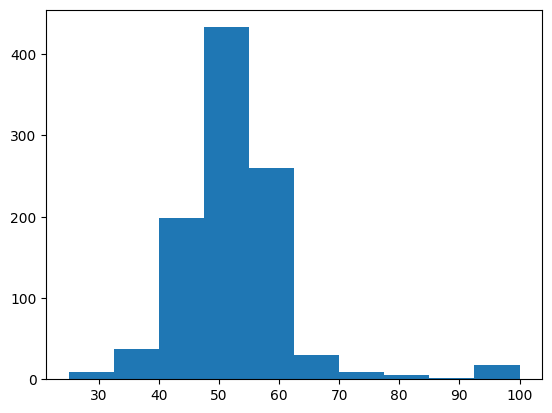

In [266]:
plt.hist(df.kl_div_blowup_step)
plt.show()

In [219]:
# df[df.final_kl_div >= 1].sort_values(by='kl_div_blowup_step', ascending=True).head(10)

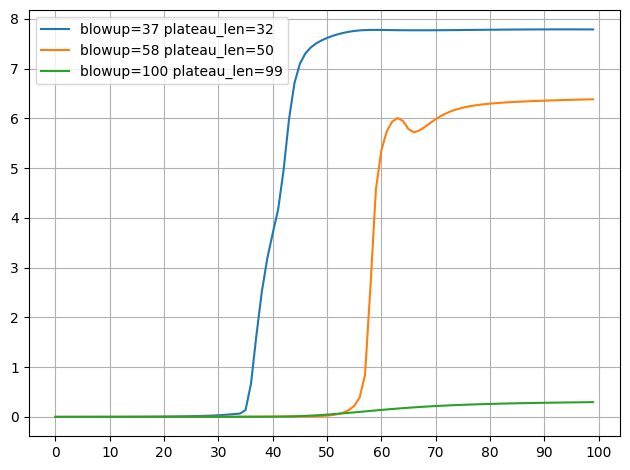

In [261]:
obs_idxs = [17, 824, 836]
steps = np.arange(0, 100, 1)

for obs_idx in obs_idxs:
    props = dict(df.loc[obs_idx])
    obs = raw_observations[obs_idx]
    label = (
        f"blowup={props['kl_div_blowup_step']} plateau_len={props['plateau_length']}"
    )
    plt.plot(steps, [s["kl_div"] for s in obs["steps"]], label=label)

plt.xticks(np.arange(0, 101, 10))
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()